# Reader-aware question generation tests
We've taken a first stab at reader-aware question generation by adding a reader-type token (e.g. `US` reader) to the input text.

Let's see how well this model does with prediction, and how well it adapts to different reader groups.

In [1]:
## load model
import torch
from transformers import AutoModelForSeq2SeqLM, BartTokenizer
cache_dir = '../../data/nyt_comments/author_data_model/model_cache/'
generation_model = AutoModelForSeq2SeqLM.from_pretrained('facebook/bart-base', cache_dir=cache_dir)
tokenizer = torch.load('../../data/nyt_comments/author_data_model/BART_tokenizer.pt')
# fix vocab size
generation_model.resize_token_embeddings(len(tokenizer))
## load trained model
trained_model_state_dict_file = '../../data/nyt_comments/author_data_model/question_generation_model/checkpoint-73500/pytorch_model.bin' # latest checkpoint model
trained_model_state_dict = torch.load(trained_model_state_dict_file)
generation_model.load_state_dict(trained_model_state_dict)

<All keys matched successfully>

In [2]:
## load validation data
import torch
val_data = torch.load('../../data/nyt_comments/author_data_model/author_type_NYT_question_data_val_data.pt')
val_data = val_data['train']
print(val_data)
mini_val_data_size = 100
mini_val_data = val_data.select(list(range(mini_val_data_size)))

Dataset(features: {'article_id': Value(dtype='string', id=None), 'location_region': Value(dtype='string', id=None), 'prior_comment_count_bin': Value(dtype='int64', id=None), 'prior_comment_len_bin': Value(dtype='int64', id=None), 'source_text': Value(dtype='string', id=None), 'target_text': Value(dtype='string', id=None), 'source_ids': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), 'target_ids': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), 'attention_mask': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None)}, num_rows: 6534)


### Generate questions

In [21]:
from importlib import reload
import data_helpers
reload(data_helpers)
from data_helpers import generate_predictions
device_name = 'cpu'
generation_method = 'sample'
pred_text = generate_predictions(generation_model, mini_val_data, tokenizer, device_name, 
                                 generation_method=generation_method, 
                                 temperature=0.7, top_p=1.0)

100%|██████████| 100/100 [03:45<00:00,  2.26s/it]


In [22]:
display(list(sorted(pred_text)))

['Could he be hiding something worse?',
 'Could he be hiding something worse?',
 'How about your Congressional buddies?',
 'How about your Congressional buddies?',
 'How about your Congressional buddies?',
 "How could a principled public servant in the run-up to the election go public with Clinton's email issues while staying silent about Trumps' Russian connections?",
 "How could a principled public servant in the run-up to the election go public with Clinton's email issues while staying silent about Trumps' Russian connections?",
 "How could a principled public servant in the run-up to the election go public with Clinton's email issues while staying silent about Trumps' Russian connections?",
 'How many columns have there been saying the Stormy Daniels story is about the money?',
 'How many columns have there been saying the Stormy Daniels story is about the money?',
 'How many columns have there been saying the Stormy Daniels story is about the money?',
 "How much more DAILY evidenc

In [17]:
from data_helpers import compare_pred_text_with_target
compare_pred_text_with_target(mini_val_data, pred_text, tokenizer, max_txt_len=7200)

*~*~*~*~*~*
source text =  federal  judge  in  Manhattan  indicated  on  Monday  that  she  was  not  prepared  to  grant  President  Trump  exclusive  first  access  to  documents  seized  in  F .  B .  I .  raids  on  the  office  of  his  personal  lawyer ,  and  said  that  she  was  considering  appointing  an  independent  lawyer  to  assist  in  reviewing  the  seized  materials .  Feeling  her  way  toward  a  resolution  of  the  high - stakes  clash  involving  Mr .  Trump  and  the  federal  prosecutors  investigating  the  lawyer ,  Michael  D .  Cohen ,  the  judge ,  Kim ba  M .  Wood ,  did  not  grant  Mr .  Trump 's  request  to  review  the  trove  of  materials  ahead  of  prosecutors .  But  she  also  decided  that  prosecutors  would  not  immediately  have  access  to  the  materials  and  that  Mr .  Trump  would  ultimately  receive  copies  of  the  documents  that  per tain  to  him .  The  courtroom  battle  over  what  to  do  with  the  seized  material  c

*~*~*~*~*~*
source text =  --  President  Trump  said  Thursday  that  the  United  States  would  consider  slapping  an  additional  $  100  billion  in  tariffs  on  the  Chinese ,  escalating  a  potentially  damaging  trade  dispute  with  Beijing .  Mr .  Trump  said  in  a  statement  that  he  was  responding  to "  unfair  retaliation "  by  China ,  which  published  a  list  on  Wednesday  of  $  50  billion  in  American  products  that  would  be  hit  by  tariffs ,  including  soy beans  and  pork .  That  move  was  a  direct  reaction  to  the  $  50  billion  in  tariffs  on  Chinese  goods  that  the  White  House  detailed  on  Tuesday ."  Rather  than  remedy  its  misconduct ,  China  has  chosen  to  harm  our  farmers  and  manufacturers ,"  Mr .  Trump  said ,  adding  that  he  has  instructed  the  United  States  trade  representative  to  determine  if  another  $  100  billion  in  tariffs  were  warranted  and ,"  if  so ,  to  identify  the  products  upo

*~*~*~*~*~*
source text = AB UL ,  Afghanistan  --  An  American  airstrike  killed  the  leader  of  the  Islamic  State  in  northern  Afghanistan ,  the  latest  in  a  series  of  crippling  setbacks  for  the  extremist  organization  in  the  country ,  according  to  American  and  Afghan  officials  on  Monday .  The  American  military  commander  in  Afghanistan ,  Gen .  John  W .  Nicholson  Jr .,  said  in  a  news  release  that  the  strike  in  F ary ab  Province  had  killed  Q ari  He k mat ullah  and  his  body guard  on  Thursday .  Mr .  He k mat ullah  was  a  key  commander  of  the  Islamic  State  in  Kh oras an ,  or  IS - K ,  as  the  Afghan  and  Pakistani  branch  of  the  Islamic  State  is  known .  General  Nicholson  described  the  killing  as  a  joint  operation  between  American  Special  Operations  troops  and  Afghan  Special  Security  Forces ,  and  said  it  was  the  latest  in  a  series  of  successful  efforts  to  kill  Islamic  State  

*~*~*~*~*~*
source text =  --  The  F .  B .  I .  raided  the  Rockefeller  Center  office  and  Park  Avenue  hotel  room  of  President  Trump 's  longtime  personal  lawyer ,  Michael  D .  Cohen ,  on  Monday  morning ,  seizing  business  records ,  emails  and  documents  related  to  several  topics ,  including  a  payment  to  a  pornographic  film  actress .  Mr .  Trump ,  in  an  extraordinarily  angry  response ,  lashed  out  hours  later  at  what  a  person  briefed  on  the  matter  said  was  an  investigation  into  possible  bank  fraud  by  Mr .  Cohen .  Mr .  Trump  accused  his  own  Justice  Department  of  perpet rating  a "  witch  hunt "  and  asserted  that  the  F .  B .  I ."  broke  in  to "  Mr .  Cohen 's  office .  The  president ,  who  spoke  at  the  White  House  before  meeting  with  senior  military  commanders  about  a  potential  missile  strike  on  Syria ,  called  the  F .  B .  I .  raid  a "  disgrace ful  situation "  and  an "  attac

*~*~*~*~*~*
source text =  --  The  F .  B .  I .  raided  the  Rockefeller  Center  office  and  Park  Avenue  hotel  room  of  President  Trump 's  longtime  personal  lawyer ,  Michael  D .  Cohen ,  on  Monday  morning ,  seizing  business  records ,  emails  and  documents  related  to  several  topics ,  including  a  payment  to  a  pornographic  film  actress .  Mr .  Trump ,  in  an  extraordinarily  angry  response ,  lashed  out  hours  later  at  what  a  person  briefed  on  the  matter  said  was  an  investigation  into  possible  bank  fraud  by  Mr .  Cohen .  Mr .  Trump  accused  his  own  Justice  Department  of  perpet rating  a "  witch  hunt "  and  asserted  that  the  F .  B .  I ."  broke  in  to "  Mr .  Cohen 's  office .  The  president ,  who  spoke  at  the  White  House  before  meeting  with  senior  military  commanders  about  a  potential  missile  strike  on  Syria ,  called  the  F .  B .  I .  raid  a "  disgrace ful  situation "  and  an "  attac

*~*~*~*~*~*
source text =  January  2017 ,  I  was  offered  a  potential  position  inside  the  newly  forming  Trump  administration  :  a  job  as  communications  director  for  a  cabinet  member .  I  had  not  supported  Mr .  Trump  and  so  the  offer  was  a  surprise ,  and  I  surprised  myself  by  even  considering  it .  While  I  didn  � �  t  pursue  the  opportunity  very  seriously  and  it  did  not  come  to  pass ,  even  the  possibility  of  having  worked  in  the  Trump  administration  has  colored  my  read  on  the  news  this  past  turbulent  year .  While  others  follow  each  new  scandal  and  the  dizz ying  parade  of  White  House  h ir ings  and  fir ings  with  g lee  or  horror ,  I  pause  to  consider  a  dangerous  near  miss .  It  has  also  given  me  a  different  perspective  on  a  side  of  philosophy  that  is  often  ignored  —  its  interaction  and  inter play  with  politics .  In  the  ancient  world ,  as  is  true  today ,  na

The model questions seem to highlight information that is reasonable:

author = NONUS_AUTHOR
target text = "How  does  that  involve  attorney - client  privilege ?"
pred text = "Why is Mueller starting a side show?"



<!-- - author = COMMENT_COUNT_0_AUTHOR
- target text = How  many  more  innocent  people  have  died  to  a venge  the  death  of  other  innocent  people ?
- pred text = How hard could it possibly be to find Assad's compound?


- author = US_AUTHOR
- target text = How  does  bringing  in  more  of  the  same  advance  the  security  and  prosperity  of  the  American  people ?
- pred text = And why are gangs of criminals violently fighting over the drug trade?

(similar sentiment)
- author = COMMENT_COUNT_0_AUTHOR
- target text = Is  this  what  America  has  come  down  to  and  what  Americans  want  to  hear  from  their  president ,  making  fun  of  American "  losers , � �  whatever  that  means ?
- pred text = How can 60 + million vote for this?


- author = COMMENT_LEN_1_AUTHOR
- target text = Why  didn 't  these  guys  just  buy  something  or  leave ?
- pred text = Why didn't they leave when they were asked? -->

The model questions do sometimes reflect author identity:

<!-- - author = US_AUTHOR
- target text = Is  Melania  still  pursuing  her  anti - bull ying  campaign ?
- pred text = How long will Republican leadership continue to let this president's behavior go on?


- author = US_AUTHOR
- target text = Will  Chris  Christie  also  be  on  this  legal  team ?
- pred text = Is Giuliani not involved in any way in Russia-gate?

(more complex reasoning)

- author = COMMENT_LEN_1_AUTHOR
- target text = The  question  is  what  enabled  the  Marines  to  conduct  themselves  as  they  did ?
- pred text = The question is what enabled the Marines to conduct themselves as they did? -->

The model questions also sometimes contradict the author's identity:

<!-- ("our country" referring to non-US country)
- author = NONUS_AUTHOR
- target text = What  it  comes  down  to  is ,  how  did  the  GOP  become  what  it  is  now ,  and  why  do  formerly  rational  and  honorable  people  follow  in  lock - step ?
- pred text = Why doe The Party list only Democrats as wanting our country's enemy impeached?

(asking basic question that is answerable from the article, rather than more complex hypothetical question)
- author = COMMENT_COUNT_1_AUTHOR
- target text = If  I 'm  eng ross ed  in  a  conversation  for  hours  and  the  cup  of  coffee  gets  cold  and  is  no  longer  desirable ,  am  I  expected  to  buy  another  cup ?
- pred text = Starbucks WHAT repercussions did this employee face? -->

The model questions are sometimes vague:

target text = "Also ,  while  things  in  China  appear  to  be  going  well ,  how  do  we  know  that ?"
source text = "How do we return to a fully functioning government?"

target text = "Too  savage  for  the  Taliban ?"
pred text = "What could possibly go wrong?"

<!-- - target text = Why  the  shifting  Syrian  and  Russian  policies  from  Trump ,  to  say  nothing  of  all  the  others ?
- pred text = How long has the US known of their existence? -->

The model tends to repeat itself sometimes, which suggests memorization of training data:

- "Is there a" blue dress" hidden somewhere here too?" (US_AUTHOR)


<!-- - "How hard could it possibly be to find Assad's compound?" (COMMENT_COUNT_0_AUTHOR)
- "How can 60 + million vote for this?" () -->

### Compare with non-author model
Let's compare this author-aware model with the model that did not receive author information.

We'll compare quantitatively first, i.e. with BLEU scores per usual.

In [48]:
## same data, different model
standard_generation_model_file = '../../data/nyt_comments/question_generation_model/checkpoint-96000/pytorch_model.bin'
standard_generation_model = AutoModelForSeq2SeqLM.from_pretrained('facebook/bart-base', cache_dir=cache_dir)
standard_tokenizer = torch.load('../../data/nyt_comments/BART_tokenizer.pt')
# fix vocab size
standard_generation_model.resize_token_embeddings(len(standard_tokenizer))
## load trained model
trained_model_state_dict_file = '../../data/nyt_comments/question_generation_model/checkpoint-96000/pytorch_model.bin' # latest checkpoint model
trained_model_state_dict = torch.load(trained_model_state_dict_file)
standard_generation_model.load_state_dict(trained_model_state_dict)

<All keys matched successfully>

In [59]:
## TODO: remove AUTHOR tokens from data before testing on no-author model
import pandas as pd
import re
raw_val_data_file = '../../data/nyt_comments/author_data_model/author_type_NYT_question_data_val_data.csv'
raw_val_data = pd.read_csv(raw_val_data_file, sep=',', index_col=False, usecols=['source_text', 'target_text', 'article_id'])
author_token_matcher = re.compile('<[A-Z0-9_]+>$')
raw_val_data = raw_val_data.assign(**{
    'source_text' : raw_val_data.loc[:, 'source_text'].apply(lambda x: author_token_matcher.sub('', x))
})
## convert back to torch format
standard_val_data_out_file = '../../data/nyt_comments/author_data_model/no_author_type_NYT_question_data_val_data.csv'
raw_val_data.to_csv(standard_val_data_out_file, sep=',', index=False)
import nlp
standard_val_data = nlp.load_dataset('csv', data_files=standard_val_data_out_file)
from data_helpers import DataProcessor
max_source_length = len(val_data['source_ids'][0])
max_target_length = len(val_data['target_ids'][0])
data_processor = DataProcessor(tokenizer=standard_tokenizer,
                               model_type='bert',
                               max_source_length=max_source_length,
                               max_target_length=max_target_length)
standard_val_torch_data = data_processor.process(standard_val_data)
standard_val_torch_data.set_format(type='torch', columns=['source_ids', 'target_ids', 'attention_mask'])
standard_val_data_torch_out_file = standard_val_data_out_file.replace('csv', 'pt')
torch.save(standard_val_torch_data, standard_val_data_torch_out_file)
standard_val_torch_data = torch.load(standard_val_data_torch_out_file)['train']

Using custom data configuration default


In [63]:
## generate questions for all articles
## standard question generator
from data_helpers import generate_predictions
device_name = 'cuda:0'
pred_text = generate_predictions(standard_generation_model, standard_val_torch_data, standard_tokenizer, device_name)

  0%|          | 0/7209 [00:00<?, ?it/s]/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/nlp/utils/py_utils.py:191: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return function(data_struct)
100%|██████████| 7209/7209 [18:45<00:00,  6.40it/s]


In [64]:
## write to file for posterity! don't want to hog GPU memory
pred_text_out_file = '../../data/nyt_comments/author_data_model/author_type_NYT_question_data_val_data_questions_from_standard_model.txt'
with open(pred_text_out_file, 'w') as pred_text_out:
    pred_text_out.write('\n'.join(pred_text))

In [65]:
## generate questions for all articles
## author-aware question generator
from data_helpers import generate_predictions
device_name = 'cuda:0'
pred_text = generate_predictions(generation_model, val_data, tokenizer, device_name)
## write to file for posterity! don't want to hog GPU memory
pred_text_out_file = '../../data/nyt_comments/author_data_model/author_type_NYT_question_data_val_data_questions_from_author_model.txt'
with open(pred_text_out_file, 'w') as pred_text_out:
    pred_text_out.write('\n'.join(pred_text))

100%|██████████| 7209/7209 [19:18<00:00,  6.22it/s]


Let's first compute BLEU scores for all predicted text.

In [4]:
# reload data
standard_model_pred_text_file = '../../data/nyt_comments/author_data_model/author_type_NYT_question_data_val_data_questions_from_standard_model.txt'
author_model_pred_text_file = '../../data/nyt_comments/author_data_model/author_type_NYT_question_data_val_data_questions_from_author_model.txt'
standard_model_pred_text = list(open(standard_model_pred_text_file, 'r'))
author_model_pred_text = list(open(author_model_pred_text_file, 'r'))
# reload validation data
import torch
val_data_file = '../../data/nyt_comments/author_data_model/author_type_NYT_question_data_val_data.pt'
val_data = val_data = torch.load(val_data_file)
val_data = val_data['train']
# convert all data to tokens
from nltk.tokenize import WordPunctTokenizer
word_tokenizer = WordPunctTokenizer()
standard_model_pred_text_tokens = list(map(word_tokenizer.tokenize, standard_model_pred_text))
author_model_pred_text_tokens = list(map(word_tokenizer.tokenize, author_model_pred_text))
val_target_text_tokens = list(map(word_tokenizer.tokenize, val_data['target_text']))
# compute BLEU scores
from data_helpers import compute_text_bleu
bleu_weights = [1.0, 0., 0., 0.]
standard_model_pred_text_bleu_scores = list(map(lambda x: compute_text_bleu(x[0], x[1], bleu_weights), zip(standard_model_pred_text_tokens, val_target_text_tokens)))
author_model_pred_text_bleu_scores = list(map(lambda x: compute_text_bleu(x[0], x[1], bleu_weights), zip(author_model_pred_text_tokens, val_target_text_tokens)))

/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider 

,model_type,bleu_score
0,standard_model,0.125000
1,standard_model,0.076923
2,standard_model,0.161348
3,standard_model,0.126390
4,standard_model,0.107354


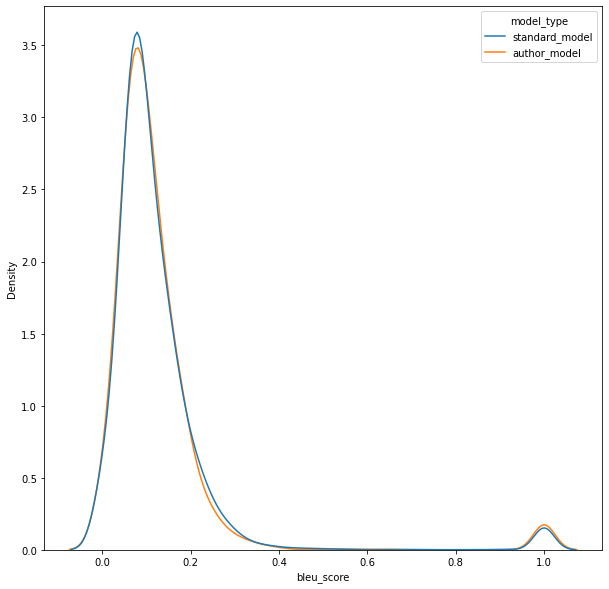

In [16]:
## are the distributions different??
import pandas as pd
combined_bleu_score_data = pd.DataFrame([standard_model_pred_text_bleu_scores, author_model_pred_text_bleu_scores], index=['standard_model', 'author_model']).transpose()
combined_bleu_score_data = pd.melt(combined_bleu_score_data, value_vars=['standard_model', 'author_model'], var_name='model_type', value_name='bleu_score')
display(combined_bleu_score_data.head())
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10,10))
sns.kdeplot(x='bleu_score', hue='model_type', data=combined_bleu_score_data)
plt.show()

OK! It seems like the models have roughly the same distributions.

In [15]:
## check for significance
from scipy.stats import wilcoxon
import numpy as np
median_diff = np.median(author_model_pred_text_bleu_scores) - np.median(standard_model_pred_text_bleu_scores)
test_stat, p_val = wilcoxon(standard_model_pred_text_bleu_scores, author_model_pred_text_bleu_scores)
print('median diff = %.3E with test stat = %.3f (p=%.3E)'%(median_diff, test_stat, p_val))

median diff = 1.451E-03 with test stat = 7982949.000 (p=5.181E-02)


OK! The author-specific model has a (weakly) higher BLEU score than the agnostic model.

I have a feeling that this is due to data bleeding: some of the articles may have duplicate questions that were spread between training and validation, and the author-specific model just learns to copy the duplicate questions to achieve "perfect" fit.

Let's re-train the author-level model with clean data.

### Old code

In [ ]:
## DEBUG: test forward pass
train_data_file = '../../data/nyt_comments/author_data_model/author_type_NYT_question_data_train_data.pt'
val_data_file = '../../data/nyt_comments/author_data_model/author_type_NYT_question_data_val_data.pt'
# train_data_file = '../../data/nyt_comments/NYT_question_data_train_data.pt'
# val_data_file = '../../data/nyt_comments/NYT_question_data_val_data.pt'
import torch
val_data = torch.load(val_data_file)
val_data = val_data['train']
# print(val_data)
train_data = torch.load(train_data_file)
train_data = train_data['train']
print(val_data)
import transformers
import sys
if('question_generation' not in sys.path):
    sys.path.append('question_generation')
from data_collator import T2TDataCollator
from train_basic_question_generation import load_training_args
model_type = 'bart'
max_source_len = len(val_data['source_ids'][0])
max_target_len = len(val_data['target_ids'][0])
from transformers import BartTokenizer
# tokenizer = BartTokenizer.from_pretrained('facebook/bart-base')
tokenizer = torch.load('../../data/nyt_comments/author_data_model/BART_tokenizer.pt')
data_collator = T2TDataCollator(
        tokenizer=tokenizer,
        model_type=model_type,
        mode="training",
        using_tpu=False
    )
model_out_dir = '../../data/nyt_comments/author_data_model/question_generation_model/'
training_args = load_training_args(model_out_dir, train_data_file, model_out_dir, val_data_file, max_source_len, max_target_len)
model_args = {
    'label_smoothing': 0,
}
cache_dir = '../../data/nyt_comments/author_data_model/model_cache/'
from transformers import AutoModelForSeq2SeqLM
model = AutoModelForSeq2SeqLM.from_pretrained('facebook/bart-base', cache_dir=cache_dir)
model.resize_token_embeddings(len(tokenizer))
from trainer import Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=val_data,
    data_collator=data_collator,
    #     prediction_loss_only=True,
    label_smoothing=model_args['label_smoothing'],
)
# trainer.train(
#         model_path=model_out_dir,
# )

In [ ]:
### DEBUG: tokenize raw text
import pandas as pd
# raw_train_data = pd.read_csv('../../data/nyt_comments/author_data_model/author_type_NYT_question_data_train_data.csv', sep=',', index_col=False)
raw_train_data = pd.read_csv('../../data/nyt_comments/NYT_question_data_train_data.csv', sep=',', index_col=False)
display(raw_train_data.head())
a = raw_train_data.iloc[0, :].loc['source_text']
a_tokens = tokenizer.encode(tokenizer.tokenize(a))
# a_str = tokenizer.convert_tokens_to_string(a_tokens)
print(len(a_tokens))
print(len(tokenizer.tokenize(a)))
# print(a_tokens)
# print(tokenizer.tokenize(a))
# test_input_data = torch.LongTensor(train_data['source_ids'][0]).reshape(1,1024)
test_input_data = torch.LongTensor(train_data['source_ids'][0]).reshape(1,1024)
device = torch.device('cuda:0')
test_input_data.to(device)
model.to(device)
# model.to('cpu')
test_output_data = model(test_input_data)
## sanity check: does the data include author type in source text?
print(tokenizer.decode(val_data['source_ids'][10], skip_special_tokens=False))
# print(tokenizer.tokenize(val_data['source_text'][0]))
# print(len(tokenizer.tokenize(val_data['source_text'][0])))